# 🧠🤖 Treinamento de Redes LSTM para Classificação

- **Deadline**: 24/08/2025
- **Entrega**: O trabalho deve ser entregue via sistema Testr.
- **Pontuação**: 50% da nota do T2 (+1 ponto extra).
- O trabalho deve ser realizado individualmente.



## Especificação


### Contexto

O trabalho consiste em realizar o treinamento de redes LSTM usando a base de dados [BBC News Archive disponível no kaggle](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive?select=bbc-news-data.csv). Esta base de dados contém 2.225 textos publicados no site de notícias da BBC news entre 2004-2005. Cada notícia foi classificada como sendo de um dos seguintes assuntos: business (negócios), entertainment (entretenimento), politics (política), sport (esportes), tech (tecnologia).

O objetivo do trabalho é treinar uma rede neural capaz de identificar o tema de um texto. 


### Implementação 

- Use o notebook de classificação de sentimentos como ponto de partida.
- use a biblioteca `kagglehub` para fazer o download do dataset no colab.
- Um dos modelos de *word embeddings* disponíveis na biblioteca `gensim` deve ser utilizado para mapear palavras em vetores. 
- Use o tipo `nn.LSTM` disponível no `pytorch` (não é necessário implementar a camada LSTM do zero).
- Os dados devem ser divididos em treino, validação e teste. Use o conjunto de validação para ajustar hiperparâmetros e para selecionar o modelo com melhor generalização. Avalie o modelo resultante usando o conjunto de teste apenas ao final. 
- Você pode optar por cortar os textos em um tamanho máximo (e.g., 100 palavras), como fizemos no notebook, para que os testes não demorem muito.
- Use o ambiente de `GPU` do colab para evitar que o treinamento demore excessivamente.
- Durante o desenvolvimento, é uma boa idéia usar um subconjunto (e.g., 10%) das notícias para que os testes sejam mais rápidos. Quando tudo estiver correto, faça o treinamento com a base completa.
- Deve ser plotado o gráfico mostrando a evolução da função de perda nos conjuntos de treino e validação. 
- Devem ser mostradas as métricas geradas pela função `classification_report` da biblioteca scikit-learn e a matriz de confusão para o conjunto de teste. 
- Faça alguns testes qualitativos com textos escritos com você (não use textos da base de dados).
- Discuta brevemente os resultados quantitativos e qualitativos (1-2 parágrafos, no máximo).



### Pontos Extras

Receberá um ponto extra, o aluno que:
- Utilizar um LLM baseado em Transformer pré-treinado (e.g., [BERT](https://medium.com/@davidlfliang/intro-getting-started-with-text-embeddings-using-bert-9f8c3b98dee6)) para mapear as notícias em *embeddings*.
- Utilizar uma rede Multilayer Perceptron para classificar os *embeddings*. 
- Comparar a performance desta solução com a LSTM. 

⚠️**IMPORTANTE**⚠️
- Não é necessário (nem recomendável considerando o prazo) tentar realizar *fine-tuning* do LLM pré-treinado.
- Estes modelos são SUPER-ULTRA-MASTER-BLASTER lentos na CPU. Use o ambiente de GPU do colab para evitar ficar 20h esperando para transformar os textos em *embeddings*.
- Salve os embeddings depois da geração para evitar ter que gerá-los novamente. Quando necessário, faça upload do arquivo novamente para o colab.

In [46]:
import os
import time
import re
from typing import List

import kagglehub
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.nn.utils.rnn import pad_sequence
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Configuração do Ambiente e Parâmetros

Antes de começar, vamos verificar a disponibilidade de uma GPU, o que acelera significativamente o treinamento de redes neurais. Também definiremos uma classe de configuração para organizar todos os hiperparâmetros e constantes do projeto em um único lugar. Isso facilita a experimentação e a reprodutibilidade dos resultados.

In [47]:
if torch.cuda.is_available():
    print("cuda:", torch.cuda.get_device_name(0))
    print("pytorch:", torch.__version__)
else:
    print("cpu.")

cuda: NVIDIA GeForce RTX 4090
pytorch: 2.5.1


In [48]:
class Config:
    def __init__(
        self,
        num_epochs: int = 30,
        batch_size: int = 64,
        learning_rate: float = 1e-3,
        patience: int = 15,
        train_split_ratio: float = 0.8,
        validation_split_ratio: float = 0.5,
        max_seq_length: int = 1000,
        torch_seed: int = 42,
        model_save_dir: str = "models",
        reports_dir: str = "reports",
        word_embedding_name: str = "glove-wiki-gigaword-200"
    ):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.patience = patience
        self.train_split_ratio = train_split_ratio
        self.validation_split_ratio = validation_split_ratio
        self.max_seq_length = max_seq_length
        self.torch_seed = torch_seed
        self.model_save_dir = model_save_dir
        self.reports_dir = reports_dir
        self.word_embedding_name = word_embedding_name

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.num_workers = os.cpu_count() // 2 if os.cpu_count() else 4

        print("Carregando modelo de word embedding... Isso pode levar alguns minutos.")
        self.glove = gensim.downloader.load(self.word_embedding_name)
        self.embedding_dim = self.glove.vector_size
        torch.manual_seed(self.torch_seed)

        os.makedirs(self.model_save_dir, exist_ok=True)
        os.makedirs(self.reports_dir, exist_ok=True)

In [49]:
config = Config()
print(config)

Carregando modelo de word embedding... Isso pode levar alguns minutos.


## Carga e Análise Exploratória dos Dados

O próximo passo é carregar os dados. Utilizaremos a biblioteca kagglehub para baixar o dataset diretamente. Em seguida, faremos uma análise inicial para entender a estrutura dos dados e a distribuição das notícias entre as diferentes categorias.

In [50]:
class DataHandler:
    DATASET_NAME = "hgultekin/bbcnewsarchive"

    def __init__(self, dataset_name: str = DATASET_NAME, seed: int = 42):
        self.dataset_name = dataset_name
        self.base_dir = kagglehub.dataset_download(dataset_name)
        self.original_df = pd.read_csv(f"{self.base_dir}/bbc-news-data.csv", sep='\t')
        self.df = self.original_df.sample(frac=1, random_state=seed).reset_index(drop=True)
        self.label_encoder = LabelEncoder()
        self.df['encoded_category'] = self.label_encoder.fit_transform(self.df['category'])
        self.num_classes = len(self.label_encoder.classes_)

    def get_data(self) -> pd.DataFrame:
        return self.df

    @staticmethod
    def _clean_text(text: str) -> str:
        text = re.sub(r"<.*?>", "", text)
        text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
        text = text.lower()
        return text

    def text_to_embeddings(self, text: str, glove_model, max_length: int) -> torch.Tensor:
        cleaned_text = self._clean_text(text)
        words = cleaned_text.split()[:max_length]

        embeddings = [glove_model[w] for w in words if w in glove_model]

        if not embeddings:
            return torch.zeros((1, glove_model.vector_size), dtype=torch.float32)

        return torch.tensor(np.array(embeddings), dtype=torch.float32)

    def create_padded_dataset(self, glove_model, max_length: int):
        print("Convertendo textos em embeddings...")
        embeddings_list = [self.text_to_embeddings(text, glove_model, max_length) for text in tqdm(self.df['content'])]

        padded_sequences = pad_sequence(embeddings_list, batch_first=True, padding_value=0.0)
        labels = torch.tensor(self.df['encoded_category'].values, dtype=torch.int64)

        return TensorDataset(padded_sequences, labels)

In [51]:
data_handler = DataHandler(seed=config.torch_seed)
df = data_handler.get_data()
df.head()

,category,filename,title,content,encoded_category
0,business,415.txt,UK house prices dip in November,"UK house prices dipped slightly in November, ...",0
1,business,421.txt,LSE 'sets date for takeover deal',The London Stock Exchange (LSE) is planning t...,0
2,sport,332.txt,Harinordoquy suffers France axe,Number eight Imanol Harinordoquy has been dro...,3
3,business,417.txt,Barclays shares up on merger talk,Shares in UK banking group Barclays have rise...,0
4,politics,337.txt,Campaign 'cold calls' questioned,Labour and the Conservatives are still teleph...,2


In [52]:
df.shape

(2225, 5)

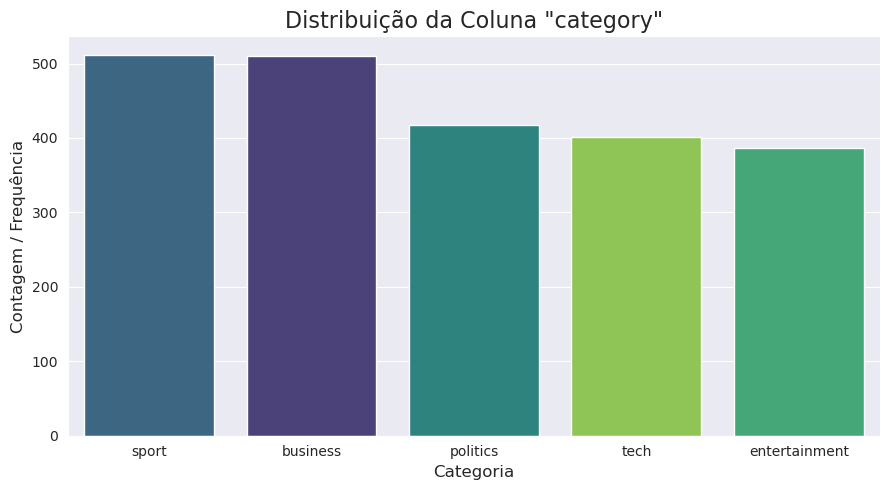

In [53]:
plt.figure(figsize=(9, 5))

order = df['category'].value_counts().index
sns.countplot(data=df, x='category', order=order, palette='viridis', hue='category', legend=False)

plt.title('Distribuição da Coluna "category"', fontsize=16)
plt.xlabel('Categoria', fontsize=12)
plt.ylabel('Contagem / Frequência', fontsize=12)

plt.tight_layout()
plt.show()

### Preparação dos Dados para o Modelo

Com os dados carregados, o próximo passo é transformá-los em um formato que a rede neural possa processar. Isso envolve três etapas principais:
- Tokenização e Embedding: Cada notícia será convertida em uma sequência de vetores numéricos (embeddings) usando o modelo GloVe pré-treinado.
- Padding: Como as notícias têm tamanhos diferentes, vamos padronizar o comprimento das sequências, adicionando zeros ao final das mais curtas até que todas atinjam o MAX_SEQ_LENGTH.
- Divisão em Treino, Validação e Teste: O conjunto de dados será dividido para treinar o modelo, ajustar seus hiperparâmetros (validação) e, finalmente, avaliá-lo em dados nunca vistos (teste).

In [54]:
full_dataset = data_handler.create_padded_dataset(config.glove, config.max_seq_length)
print(f"\nFormato do tensor de dados (amostras, max_len, emb_dim): {full_dataset.tensors[0].shape}")
print(f"Formato do tensor de rótulos (amostras,): {full_dataset.tensors[1].shape}")

Convertendo textos em embeddings...


100%|██████████| 2225/2225 [00:01<00:00, 1820.68it/s]



Formato do tensor de dados (amostras, max_len, emb_dim): torch.Size([2225, 1000, 200])
Formato do tensor de rótulos (amostras,): torch.Size([2225])


In [55]:
# Divisão inicial em treino e um conjunto temporário (validação + teste)
train_size = int(config.train_split_ratio * len(full_dataset))
temp_size = len(full_dataset) - train_size
train_dataset, temp_dataset = random_split(full_dataset, [train_size, temp_size])

# Divisão do conjunto temporário em validação e teste
val_size = int(config.validation_split_ratio * temp_size)
test_size = temp_size - val_size
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

# Criação dos DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size)

print(f"Tamanho do conjunto de treino: {len(train_dataset)}")
print(f"Tamanho do conjunto de validação: {len(val_dataset)}")
print(f"Tamanho do conjunto de teste: {len(test_dataset)}")

Tamanho do conjunto de treino: 1780
Tamanho do conjunto de validação: 222
Tamanho do conjunto de teste: 223


### Definição do Modelo LSTM
Agora, vamos construir a arquitetura da nossa rede neural. Ela será composta por uma camada LSTM, que processará a sequência de embeddings, seguida por uma camada linear (totalmente conectada) que realizará a classificação final, prevendo a probabilidade de a notícia pertencer a cada uma das cinco categorias.

In [56]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, n_layers, dropout_prob):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_prob if n_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Inicializa os estados ocultos e da célula com zeros
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)

        # A saída da LSTM contém as saídas de todos os passos de tempo
        # Nós estamos interessados apenas na última saída
        out, _ = self.lstm(x, (h0, c0))

        # Pega a saída do último passo de tempo
        out = out[:, -1, :]

        out = self.dropout(out)
        out = self.fc(out)

        return out

### Treinamento e Avaliação

Nesta fase, criamos uma classe Trainer para encapsular toda a lógica de treinamento e avaliação. Isso inclui o loop de treinamento, o cálculo da função de perda, a otimização dos pesos da rede (backpropagation) e a validação do modelo a cada época. Também implementamos o mecanismo de early stopping para interromper o treinamento se a performance no conjunto de validação não melhorar, evitando o superajuste (overfitting).

In [57]:
class Trainer:
    """
    Gerencia o ciclo de vida do treinamento e avaliação do modelo.
    """
    def __init__(self, model, config, train_loader, val_loader, test_loader):
        self.model = model.to(config.device)
        self.config = config
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        self.history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def _train_epoch(self):
        self.model.train()
        total_loss = 0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.config.device), labels.to(self.config.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    def _validate_epoch(self):
        self.model.eval()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.config.device), labels.to(self.config.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        accuracy = correct_predictions / total_samples
        return total_loss / len(self.val_loader), accuracy

    def run_training(self):
        print("Iniciando o treinamento...")
        for epoch in range(self.config.num_epochs):
            train_loss = self._train_epoch()
            val_loss, val_accuracy = self._validate_epoch()

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)

            print(f"Época {epoch+1}/{self.config.num_epochs} | "
                  f"Perda de Treino: {train_loss:.4f} | "
                  f"Perda de Validação: {val_loss:.4f} | "
                  f"Acurácia de Validação: {val_accuracy:.4f}")

            # Lógica de Early Stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                torch.save(self.model.state_dict(), os.path.join(self.config.model_save_dir, 'best_model.pth'))
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.config.patience:
                    print("Early stopping ativado!")
                    break

        # Carrega o melhor modelo salvo
        self.model.load_state_dict(torch.load(os.path.join(self.config.model_save_dir, 'best_model.pth')))
        print("Treinamento concluído.")

    def plot_loss_curves(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['train_loss'], label='Perda de Treino')
        plt.plot(self.history['val_loss'], label='Perda de Validação')
        plt.title('Evolução da Função de Perda')
        plt.xlabel('Épocas')
        plt.ylabel('Perda (Cross-Entropy)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate_on_test_set(self, label_names):
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.config.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        print("Relatório de Classificação no Conjunto de Teste:")
        print(classification_report(all_labels, all_preds, target_names=label_names))

        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap='Blues')
        plt.title('Matriz de Confusão no Conjunto de Teste')
        plt.show()

In [58]:
lstm_model = LSTMClassifier(
    embedding_dim=config.embedding_dim,
    hidden_dim=32,
    num_classes=data_handler.num_classes,
    n_layers=2,
    dropout_prob=0.5
)

trainer = Trainer(
    model=lstm_model,
    config=config,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)

trainer.run_training()

Iniciando o treinamento...
Época 1/30 | Perda de Treino: 1.6085 | Perda de Validação: 1.6022 | Acurácia de Validação: 0.2027
Época 2/30 | Perda de Treino: 1.6060 | Perda de Validação: 1.6026 | Acurácia de Validação: 0.2027
Época 3/30 | Perda de Treino: 1.6062 | Perda de Validação: 1.6018 | Acurácia de Validação: 0.2027
Época 4/30 | Perda de Treino: 1.6042 | Perda de Validação: 1.5997 | Acurácia de Validação: 0.2703
Época 5/30 | Perda de Treino: 1.6028 | Perda de Validação: 1.6000 | Acurácia de Validação: 0.1982
Época 6/30 | Perda de Treino: 1.6035 | Perda de Validação: 1.5982 | Acurácia de Validação: 0.2027
Época 7/30 | Perda de Treino: 1.6027 | Perda de Validação: 1.5971 | Acurácia de Validação: 0.2027
Época 8/30 | Perda de Treino: 1.6019 | Perda de Validação: 1.5964 | Acurácia de Validação: 0.2027
Época 9/30 | Perda de Treino: 1.6012 | Perda de Validação: 1.5939 | Acurácia de Validação: 0.2748
Época 10/30 | Perda de Treino: 1.6019 | Perda de Validação: 1.5950 | Acurácia de Validação:

/tmp/ipykernel_517455/1839264611.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(os.path.join(self.config.model_save_dir, 'best_mo

### Análise dos Resultados
Após o treinamento, o primeiro passo é visualizar a curva de aprendizado. O gráfico da função de perda ao longo das épocas nos ajuda a diagnosticar problemas como overfitting (quando a perda de treino continua caindo, mas a de validação começa a subir) ou underfitting (quando ambas as perdas permanecem altas).

Em seguida, avaliamos o desempenho final do modelo no conjunto de teste, que ele nunca viu antes. Para isso, geramos o relatório de classificação, que detalha métricas como precisão, recall e F1-score para cada categoria, e a matriz de confusão, que visualiza os acertos e erros do classificador.

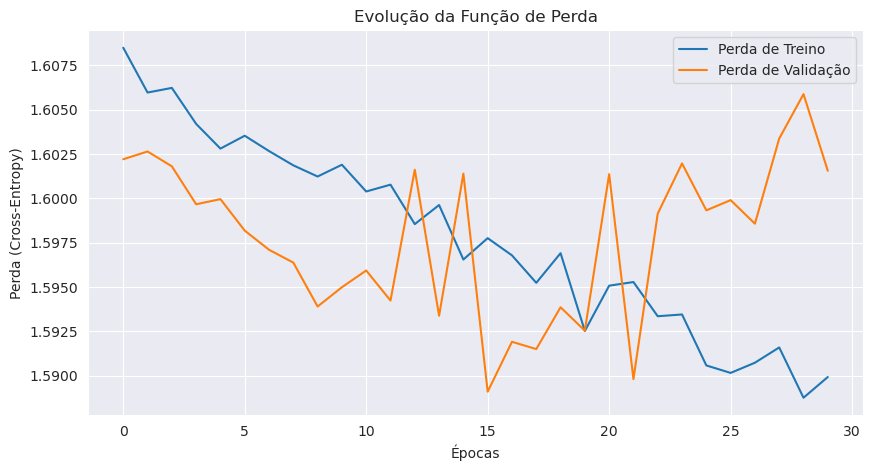

In [59]:
trainer.plot_loss_curves()

Relatório de Classificação no Conjunto de Teste:
               precision    recall  f1-score   support

     business       0.00      0.00      0.00        57
entertainment       0.00      0.00      0.00        36
     politics       0.00      0.00      0.00        37
        sport       0.27      1.00      0.42        60
         tech       0.00      0.00      0.00        33

     accuracy                           0.27       223
    macro avg       0.05      0.20      0.08       223
 weighted avg       0.07      0.27      0.11       223



/home/hygo2025/.local/share/mamba/envs/rna/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hygo2025/.local/share/mamba/envs/rna/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hygo2025/.local/share/mamba/envs/rna/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

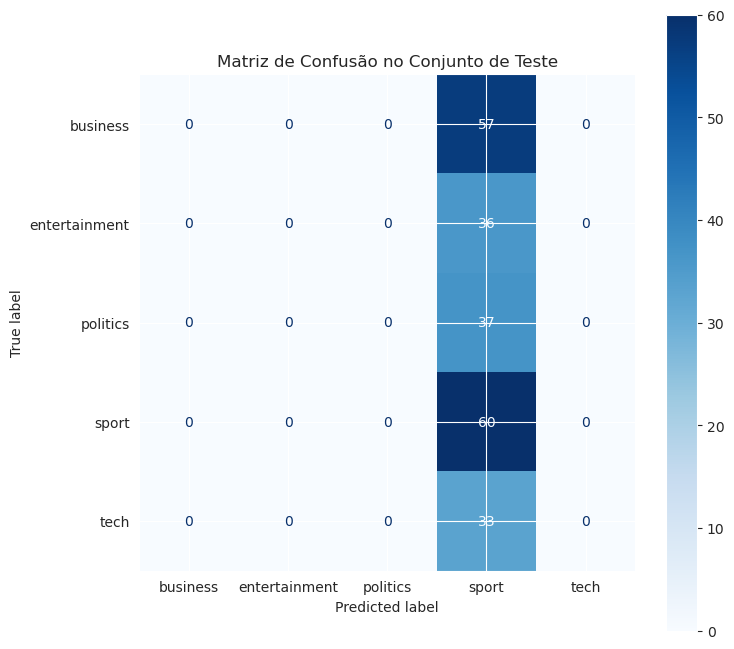

In [60]:
label_names = data_handler.label_encoder.classes_
trainer.evaluate_on_test_set(label_names)

### Testes Qualitativos

A avaliação quantitativa é importante, mas também é útil ver como o modelo se comporta com exemplos do mundo real. Abaixo, testamos o classificador com algumas frases novas para ter uma ideia de sua capacidade de generalização.

In [61]:
def predict_text(text, model, data_handler, config):
    model.eval()
    with torch.no_grad():
        # Pré-processa o texto de entrada da mesma forma que os dados de treino
        embeddings = data_handler.text_to_embeddings(text, config.glove, config.max_seq_length)
        # Adiciona uma dimensão de batch (tamanho 1)
        input_tensor = embeddings.unsqueeze(0).to(config.device)

        output = model(input_tensor)
        _, predicted_idx = torch.max(output, 1)

        predicted_label = data_handler.label_encoder.inverse_transform([predicted_idx.item()])[0]
        return predicted_label

# Exemplos de testes
text1 = "The government announced a new tax policy today that will affect all major corporations."
text2 = "The movie broke all box office records on its opening weekend, with critics praising the special effects."
text3 = "The home team won the championship in a thrilling final match that went into overtime."

print(f"Texto: '{text1}'\nCategoria Prevista: {predict_text(text1, trainer.model, data_handler, config)}\n")
print(f"Texto: '{text2}'\nCategoria Prevista: {predict_text(text2, trainer.model, data_handler, config)}\n")
print(f"Texto: '{text3}'\nCategoria Prevista: {predict_text(text3, trainer.model, data_handler, config)}\n")

Texto: 'The government announced a new tax policy today that will affect all major corporations.'
Categoria Prevista: tech

Texto: 'The movie broke all box office records on its opening weekend, with critics praising the special effects.'
Categoria Prevista: entertainment

Texto: 'The home team won the championship in a thrilling final match that went into overtime.'
Categoria Prevista: entertainment

